In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

2024-04-25 08:21:59.953896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 08:21:59.954014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 08:22:00.056046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
dataset_dir = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [4]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.equalizeHist(image)
            image = cv2.resize(image,(256, 256))  # Resize images to 256x256 pixels
            image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]

            images.append(image)
            labels.append(label)
    return images, labels

In [5]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)
# Load and preprocess tuberculosis images
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)

In [6]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [7]:
images = np.array(images)
labels = np.array(labels)

In [8]:
df1=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-shenzhen/shenzhen_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-shenzhen/images/images/'
df1['equalized_filename'] = df1['study_id'].apply(lambda x: base_path+x)
df2=pd.read_csv('/kaggle/input/tuberculosis-chest-xrays-montgomery/montgomery_metadata.csv')
base_path='/kaggle/input/tuberculosis-chest-xrays-montgomery/images/images/'
df2['equalized_filename'] = df2['study_id'].apply(lambda x: base_path+x)
df=pd.concat([df1, df2], ignore_index=True)
df['target']=df['findings'].apply(lambda x:0 if x=='normal' else 1)
df['target'] = df['target'].astype(str)
df = df.sample(frac=1).reset_index(drop=True)

In [9]:
def preprocess_images_cxr(image_dir):
    images = []
    for filename in image_dir:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        image = cv2.equalizeHist(image)
        image = cv2.resize(image,(256, 256))  # Resize images to 256x256 pixels
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
        images.append(image)
    return images

In [10]:
tuberculosis_images_new = preprocess_images_cxr(df['equalized_filename'])
tuberculosis_labels_new= df['target'].values

In [11]:
new_images=np.array(tuberculosis_images_new)
new_labels=np.array(tuberculosis_labels_new)

In [12]:
images= np.concatenate((images, new_images), axis=0)
images.shape

(5000, 256, 256, 3)

In [13]:
labels=np.concatenate((labels,new_labels),axis=0)
labels.shape

(5000,)

In [14]:
labels=labels.astype(int)

In [15]:
images, new_images, labels, new_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Input

from tensorflow.keras.optimizers import Adam

In [17]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 904.3 kB/s eta 0:00:00a 0:00:01


In [18]:
import efficientnet.tfkeras as efn

In [19]:
from tensorflow.keras.layers import Flatten, Conv2D, BatchNormalization,SpatialDropout2D,GlobalMaxPooling2D,Dropout

In [20]:
# base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# # Optionally freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Add custom classification head
# model = Sequential([
#     Input(shape=(256, 256, 3)),
#     base_model,
#     Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Add a convolutional layer
#     SpatialDropout2D(0.5),  # Add spatial dropout
#     GlobalMaxPooling2D(),   # Use GlobalMaxPooling instead of GlobalAveragePooling
#     Dense(256, activation='relu'),
#     Dense(128, activation='relu'),  # Additional Dense layer
#     Dense(64, activation='relu'),   # Additional Dense layer
#     Dense(1, activation='sigmoid')
# ])
# model.compile(optimizer='adam',
#                     loss='binary_crossentropy',
#                     metrics=['accuracy'])

# # Print model summary
# model.summary()

In [21]:
# history = model.fit(images, labels,
#                           epochs=25,
#                           batch_size=32,
#                           validation_data=(new_images, new_labels))

In [22]:
# test_loss, test_accuracy =model.evaluate(new_images, new_labels)

# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

In [23]:
# y_pred_probs = model.predict(new_images)

# # Convert probabilities to binary predictions
# y_pred_binary = (y_pred_probs > 0.5).astype(int)

# # Convert test labels to binary format (0: Normal, 1: Tuberculosis)
# test_labels_binary = (new_labels > 0.5).astype(int)
# classification_metrics = classification_report(test_labels_binary, y_pred_binary)
# print("Classification Report:")
# print(classification_metrics)

# # Confusion matrix
# conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
# print("Confusion Matrix:")
# print(conf_matrix)

In [24]:
# class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()

In [25]:
base_model = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Optionally freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
model = Sequential([
    Input(shape=(256, 256, 3)),
    base_model,
    Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Add a convolutional layer
    BatchNormalization(),  # Add BatchNormalization layer
    SpatialDropout2D(0.3),  # Add SpatialDropout2D layer
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),  # Add BatchNormalization layer
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),  # Add BatchNormalization layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),  # Add BatchNormalization layer
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Print model summary
model.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)    │ (None, 8, 8, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 6, 6, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 6, 6, 128)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,747,677 (25.74 MB)

 Trainable params: 2,696,961 (10.29 MB)

 Non-trainable params: 4,050,716 (15.45 MB)

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [28]:
history = model.fit(images, labels,
                          epochs=25,
                          batch_size=32,
                          validation_data=(new_images, new_labels),
                          callbacks=[reduce_lr, early_stopping])

Epoch 1/25
  2/125 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.4922 - loss: 0.8209    

I0000 00:00:1714033609.795927     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714033609.850502     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7606 - loss: 0.4927

W0000 00:00:1714033624.139268     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1714033632.724671     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.7619 - loss: 0.4908 - val_accuracy: 0.9560 - val_loss: 0.1461 - learning_rate: 0.0010
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9393 - loss: 0.1919 - val_accuracy: 0.9310 - val_loss: 0.1747 - learning_rate: 0.0010
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9510 - loss: 0.1421 - val_accuracy: 0.9680 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9564 - loss: 0.1196 - val_accuracy: 0.9290 - val_loss: 0.1974 - learning_rate: 0.0010
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9576 - loss: 0.1125 - val_accuracy: 0.9760 - val_loss: 0.0695 - learning_rate: 0.0010
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.9639 - loss: 0.1011 - val_accuracy: 0.9710 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.9702 - loss: 0.0811 - va

In [29]:
test_loss, test_accuracy =model.evaluate(new_images, new_labels)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9764 - loss: 0.0620
Test Loss: 0.06164518743753433
Test Accuracy: 0.9800000190734863


In [30]:
y_pred_probs = model.predict(new_images)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Convert test labels to binary format (0: Normal, 1: Tuberculosis)
test_labels_binary = (new_labels > 0.5).astype(int)
classification_metrics = classification_report(test_labels_binary, y_pred_binary)
print("Classification Report:")
print(classification_metrics)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_binary, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

 5/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

W0000 00:00:1714033762.579833     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       781
           1       0.96      0.95      0.95       219

    accuracy                           0.98      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.98      0.98      0.98      1000

Confusion Matrix:
[[773   8]
 [ 12 207]]


W0000 00:00:1714033769.330622     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


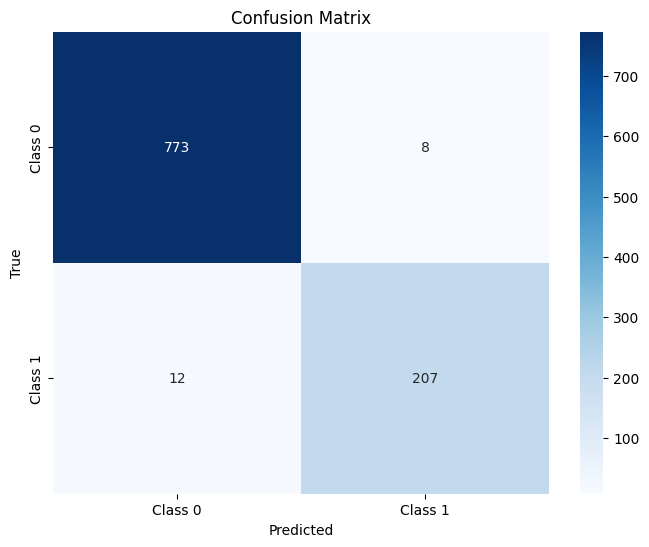

In [31]:
class_labels = ["Class 0", "Class 1"]  # Replace with your actual class labels if needed

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()